# CSCE 479/879 Hackathon: Gradient Feature Attribution

Written by Eleanor Quint

Modified by Mrinal Rawool and Stephen Scott

Topics:
- Gradient Feature Attribution
- Integrated Gradient Feature Attribution

This is all set up in a IPython notebook so you can run any code you want to experiment with. Feel free to edit any cell, or add some to run your own code.

In [ ]:
# We'll start with our library imports...
from __future__ import print_function

import numpy as np                 # to use numpy arrays
import tensorflow as tf            # to specify and run computation graphs
import tensorflow_datasets as tfds # to load training data
import matplotlib.pyplot as plt    # to visualize data and draw plots
from tqdm import tqdm              # to track progress of loops
import tensorflow_hub as hub       # to load pre-trained models

DATA_DIR = './tensorflow-datasets/'

### Gradient Feature Attribution

We would like to understand what part of an input image a convolutional classifier is "looking at" in the process of making a classification. We call this process "feature attribution". **The goal is to create a heatmap of which pixels in the input image are most important to the model output**. The most basic method of doing this is by **calculating the gradients of the output with respect to the input image rather than the weights of the model**. Where the gradients are largest, the pixels are the most important.

We'll load ImageNet-A as the dataset, a set of images labelled with ImageNet labels that were obtained by collecting new data and keeping only those images that ResNet-50 models fail to correctly classify. This should lead to some interesting results in the visualizations. We'll load the Inception model to classify the data.

In [ ]:
imagenet_ds = tfds.load('imagenet_a', data_dir=DATA_DIR)
test_ds = imagenet_ds['test'].shuffle(1024)

model = tf.keras.Sequential([
    hub.KerasLayer(
        name='inception_v1',
        handle='https://tfhub.dev/google/imagenet/inception_v1/classification/4',
        trainable=False),
])
model.build([None, 224, 224, 3])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v1 (KerasLayer)   (None, 1001)              6633209   
                                                                 
Total params: 6633209 (25.30 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 6633209 (25.30 MB)
_________________________________________________________________


To identify what the ImageNet labels are in text we'll load the labels as an array.

### Function to load the label names

In [ ]:
def load_imagenet_labels(file_path):
    labels_file = tf.keras.utils.get_file('ImageNetLabels.txt', file_path)
    with open(labels_file) as reader:
        f = reader.read()
        labels = f.splitlines()
    return np.array(labels)

imagenet_labels = load_imagenet_labels('https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

<class 'dict'>
dict_keys(['file_name', 'image', 'label'])
(375, 500, 3)
tf.Tensor(132, shape=(), dtype=int64) => little blue heron


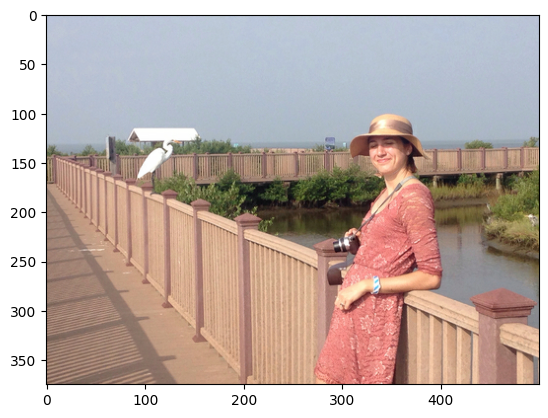

In [ ]:
for img in test_ds:
    print(type(img))
    print(img.keys())
    print(img['image'].shape)
    print(img['label'], "=>", imagenet_labels[img['label']])
    plt.imshow(img['image'])
    break

### What happens when you pass inputs to the model

In [ ]:
input = img['image']

In [ ]:
output = model(tf.expand_dims(tf.image.resize_with_pad(input, 224, 224) / 255., axis=0))

In [ ]:
output

<tf.Tensor: shape=(1, 1001), dtype=float32, numpy=
array([[-0.18731225,  1.1269369 , -1.1097212 , ..., -0.32072553,
         2.118146  ,  0.5896632 ]], dtype=float32)>

In [ ]:
print(np.argmax(output[0])) # predicted integer label
print(imagenet_labels[img['label']]) # true
print(imagenet_labels[np.argmax(output[0])]) # pred

461
little blue heron
breakwater


<BarContainer object of 1001 artists>

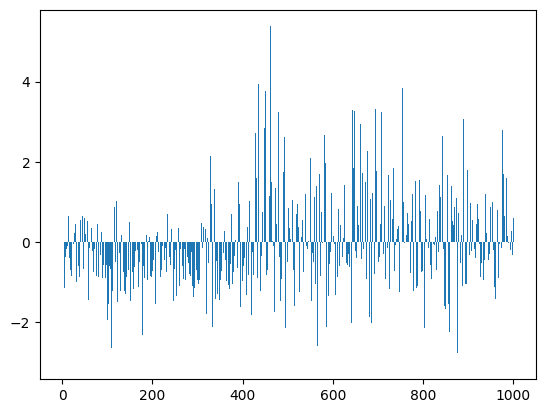

In [ ]:
plt.bar(x=np.linspace(start=1, stop = 1001, num=1001) , height=output[0])

### Compute grads wrt image

We'll define a function specifically to compute gradients of one output class in particular with respect to the model input.

In [ ]:
def compute_gradients(images, target_class_idx):
    with tf.GradientTape() as tape:
        # We have to use tape.watch to calculate gradients of a non-variable tensor
        tape.watch(images)
        logits = model(images)
        probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
    return tape.gradient(probs, images)

Finally, we'll get some data, calculate the model prediction, and calculate the gradients with respect to that predicted class.

(224, 224, 3)
(1,)
(1, 224, 224, 3)
Predicted Label: swimming trunks
Correct Label: apiary


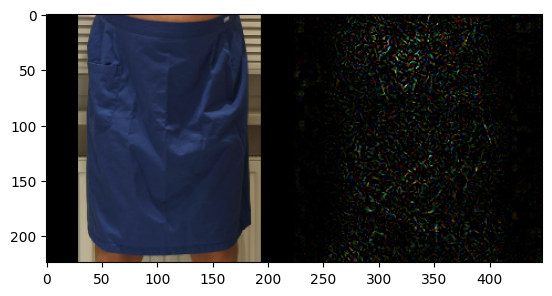

In [ ]:
for x in test_ds:
    # this casts to float, so we'll divide by 255 right away to get [0,1] data
    img = tf.image.resize_with_pad(x['image'], 224, 224) / 255.
    print(img.shape) # (224, 224, 3)
    model_prediction = tf.argmax(model(tf.expand_dims(img, 0)), axis=1)
    print(model_prediction.shape) # (1,)
    grads = compute_gradients(tf.expand_dims(img, 0), model_prediction.numpy()[0]) # every pixel's contri towards the predicted label
    print(grads.shape) # (1, 224, 224, 3)
    break

# clip to positive value gradients and scale
grads = tf.clip_by_value(grads, 0, 1)[0]
grads = grads / tf.reduce_max(grads)

print("Predicted Label:", imagenet_labels[model_prediction.numpy()[0]])
print("Correct Label:", imagenet_labels[x['label'].numpy()])
plt.imshow(tf.concat([img, grads], axis=1))

### Integrated Gradient Feature Attribution

Unfortunately, one gradient calculation doesn't tell the full story. It is only a local calculation at the specific value of the pixel. Integrated gradients improves on this by calculating an integral of the pixel gradients by interpolating the pixel from zero to its true value and collecting all the gradients calculated in the in-between steps.

We do this by establishing a baseline and interpolating between the baseline and our image in steps.

In [ ]:
baseline = tf.zeros_like(img)

# Generate uniformly spaced coefficients for interpolating between baseline and image
interp_steps=50
alphas = tf.linspace(start=0.0, stop=1.0, num=interp_steps+1) # 50 fp between 0, 1

def interpolate_images_1(baseline, image, alphas):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    baseline_x = tf.expand_dims(baseline, axis=0) # add batch dim
    input_x = tf.expand_dims(image, axis=0)
    delta = input_x - baseline_x
    images = baseline_x +  alphas_x * delta # multiply by varying degrees controlled by alpha
    # return images
    return images, baseline_x, delta

# interpolated_images = interpolate_images(
interpolated_images, baseline_x, delta = interpolate_images_1(
    baseline=baseline,
    image=img,
    alphas=alphas)

In [ ]:
interpolated_images.shape

TensorShape([51, 224, 224, 3])

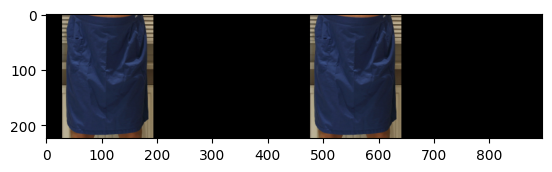

In [ ]:
plt.imshow(tf.concat([img, baseline_x[0], delta[0], interpolated_images[0]], axis=1))

In [ ]:
alphas

<tf.Tensor: shape=(51,), dtype=float32, numpy=
array([0.        , 0.02      , 0.04      , 0.06      , 0.08      ,
       0.09999999, 0.12      , 0.14      , 0.16      , 0.17999999,
       0.19999999, 0.22      , 0.24      , 0.26      , 0.28      ,
       0.29999998, 0.32      , 0.34      , 0.35999998, 0.38      ,
       0.39999998, 0.42      , 0.44      , 0.45999998, 0.48      ,
       0.5       , 0.52      , 0.53999996, 0.56      , 0.58      ,
       0.59999996, 0.62      , 0.64      , 0.65999997, 0.68      ,
       0.7       , 0.71999997, 0.74      , 0.76      , 0.78      ,
       0.79999995, 0.82      , 0.84      , 0.85999995, 0.88      ,
       0.9       , 0.91999996, 0.94      , 0.96      , 0.97999996,
       1.        ], dtype=float32)>

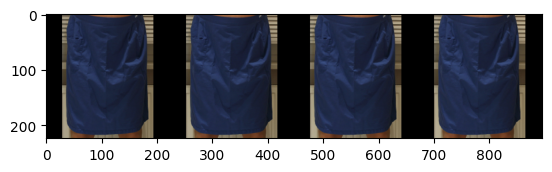

In [ ]:
plt.imshow(tf.concat([interpolated_images[46],
                      interpolated_images[47],
                      interpolated_images[48],
                      interpolated_images[49]], axis=1))

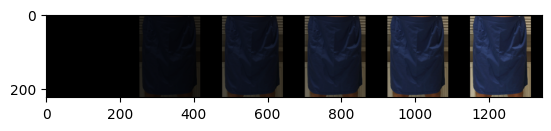

In [ ]:
plt.imshow(tf.concat([interpolated_images[0],
                      interpolated_images[10],
                      interpolated_images[20],
                      interpolated_images[30],
                      interpolated_images[40],
                      interpolated_images[50]], axis=1))

### Functions:

1. Calculate integral approximations
2. Interpolate images
3. Calculate integrated gradients

We'll use quadrature, [a type of numerical integration](https://en.wikipedia.org/wiki/Numerical_integration), to get a good estimate of the integral.

With the interpolated images and the ability to calculate the integral, we can calculate the integrated gradient.

In [ ]:
def integral_approximation(gradients):
    # riemann_trapezoidal
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    integrated_gradients = tf.math.reduce_mean(grads, axis=0)
    return integrated_gradients

def interpolate_images(baseline, image, alphas):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    baseline_x = tf.expand_dims(baseline, axis=0) # add batch dim
    input_x = tf.expand_dims(image, axis=0)
    delta = input_x - baseline_x
    images = baseline_x +  alphas_x * delta
    # return images
    return images

def integrated_gradients(image,
                         target_class_idx,
                         m_steps=50,
                         batch_size=32):
    # 1. Generate alphas.
    baseline = tf.zeros_like(image)
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

    # Initialize TensorArray outside loop to collect gradients.
    gradient_batches = tf.TensorArray(tf.float32, size=m_steps+1)

    # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
    for alpha in tqdm(tf.range(0, len(alphas), batch_size)):
        from_ = alpha
        to = tf.minimum(from_ + batch_size, len(alphas))
        alpha_batch = alphas[from_:to]

        # 2. Generate interpolated inputs between baseline and input.
        interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                           image=image,
                                                           alphas=alpha_batch)

        # 3. Compute gradients between model outputs and interpolated inputs.
        gradient_batch = compute_gradients(images=interpolated_path_input_batch,
                                           target_class_idx=target_class_idx)

        # Write batch indices and gradients to extend TensorArray.
        gradient_batches = gradient_batches.scatter(tf.range(from_, to), gradient_batch)

    # Stack path gradients together row-wise into single tensor.
    total_gradients = gradient_batches.stack()

    # 4. Integral approximation through averaging gradients.
    avg_gradients = integral_approximation(gradients=total_gradients)

    # 5. Scale integrated gradients with respect to input.
    integrated_gradients = (image - baseline) * avg_gradients

    return integrated_gradients

### Plot images

And finally, plot them.

In [ ]:
def plot_img_attributions(image,
                          target_class_idx,
                          m_steps=50,
                          cmap=None,
                          overlay_alpha=0.4):

    attributions = integrated_gradients(image=image,
                                        target_class_idx=target_class_idx,
                                        m_steps=m_steps)

    # Sum of the attributions across color channels for visualization.
    # The attribution mask shape is a grayscale image with height and width
    # equal to the original image.
    attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

    fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

    # leave this in as long as the keras VGG-19 preprocessing is being used
    image = image[:,:,::-1]

    axs[0, 0].set_title('Baseline image')
    axs[0, 0].imshow(tf.zeros_like(image))
    axs[0, 0].axis('off')

    axs[0, 1].set_title('Original image')
    axs[0, 1].imshow(image)
    axs[0, 1].axis('off')

    axs[1, 0].set_title('Attribution mask')
    axs[1, 0].imshow(attribution_mask, cmap=cmap)
    axs[1, 0].axis('off')

    axs[1, 1].set_title('Overlay')
    axs[1, 1].imshow(attribution_mask, cmap=cmap)
    axs[1, 1].imshow(image, alpha=overlay_alpha)
    axs[1, 1].axis('off')

    plt.tight_layout()
    return fig

The result may or may not make sense to a viewer (and may or may not mean much depending on the problem), but it's at least one mathematical description of how important each pixel is to the classifier.

100%|██████████| 5/5 [00:43<00:00,  8.64s/it]


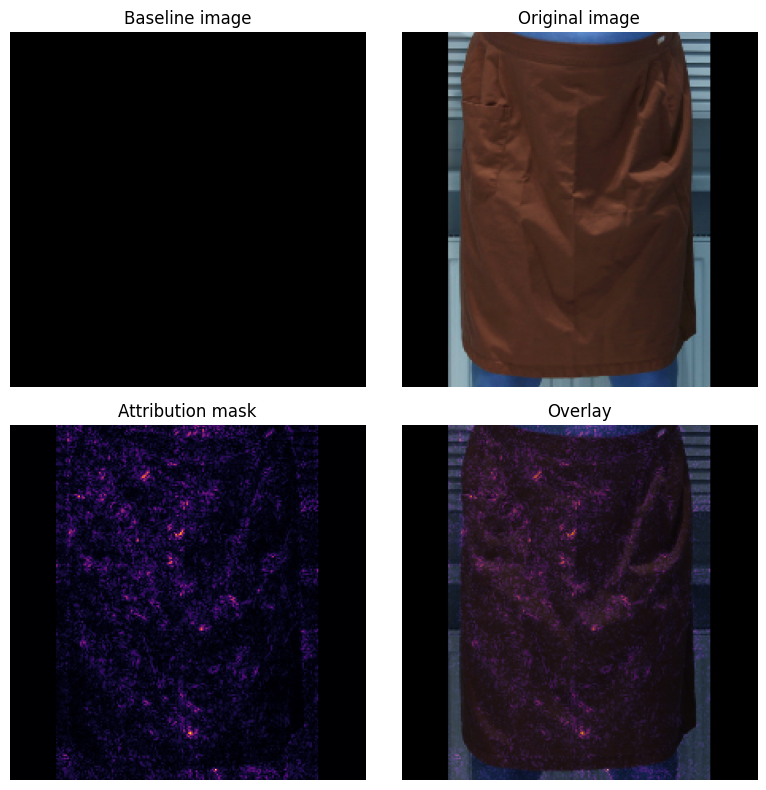

In [ ]:
_ = plot_img_attributions(image=img,
                          target_class_idx=x['label'],
                          m_steps=128,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)

Thanks to [TensorFlow's documentation](https://www.tensorflow.org/tutorials/interpretability/integrated_gradients) for much of the code used in the Integrated Gradient example.

### Homework

None! This is the final hackathon. I hope your work  goes well in this course and your other endeavors.